# Transform

Do imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from ae483tools import *
from math import sin,cos
from np2pth import get_system_wrapper, get_controller_wrapper, get_w_func_wrapper_from_checkpoint
import importlib

Load data from a flight in which the drone took off, moved in a square, and landed.

In [2]:
with open('CCM_MO2_constrained_0.5_25_0.8_T7hlf.json', 'r') as f:
    log_data = json.load(f)

w_lb,w_ub,gamma_CT = 0.1,10,0.8
cn =w_ub/w_lb
dt=1/100
gamma =  np.sqrt((1- 2*dt*gamma_CT)* (1/cn))    #*(cn)
print('gamma :',gamma)
data_drone= log_data['drone']

# Compute Lyapunov modelling error
controller = get_controller_wrapper('log_QUADROTORM_R100_0.5_25_0.8/controller_best.pth.tar')
w_func = get_w_func_wrapper_from_checkpoint(checkpoint_path='log_QUADROTORM_R100_0.5_25_0.8/model_best.pth.tar', w_lb=0.5, task = "QUADROTOR_9D")

# acc_z=data_drone['acc.z']
# print(acc_z.keys())

data_mocap = log_data['mocap']

data_reference =  np.load('quadN_MO2_T7hlf_constrained.npz')   #np.load('quadN_traj1_T5.npz') #np.load('quadN_hover_200hz.npz')
Xstar = data_reference['X'].T
Ustar = data_reference['U'].T

gamma : 0.09919677414109795


In [3]:

xcurr = np.array(log_data['controller']['xcurr'])  # shape (T, 9)
u         = np.array(log_data['controller']['u'])         # Shape: (T, 3)
f_cmd     = np.array(log_data['controller']['f_cmd'])     # Shape: (T,)
timestamp = np.array(log_data['controller']['timestamp'])*dt # Shape: (T,)
att_target = np.array(log_data['controller']['target_attitude'])   #shape (T,4)

Plot $x, y$ data.

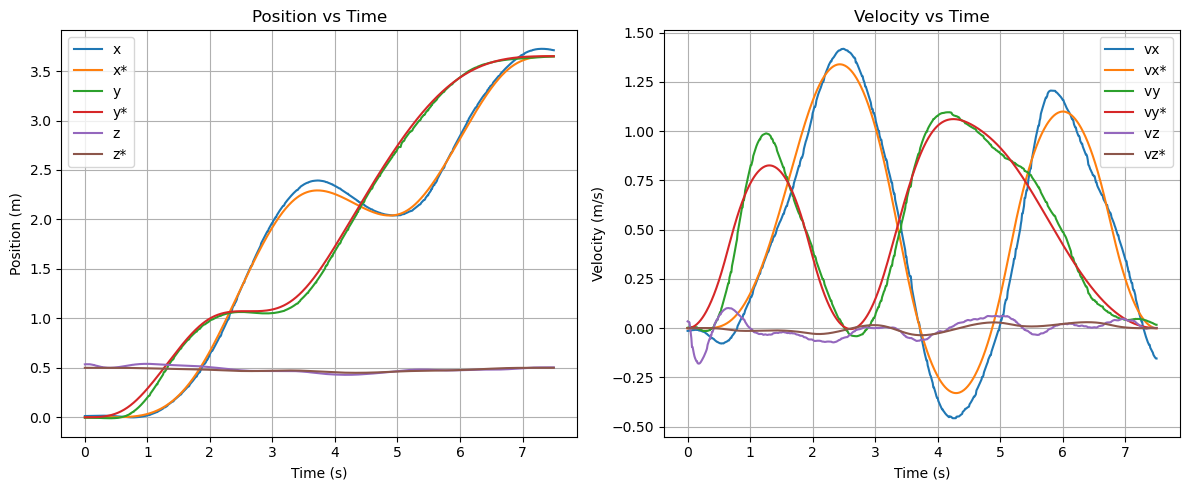

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# Plot position (x, y, z)
axs[0].plot(timestamp, xcurr[:, 0], label='x')
axs[0].plot(timestamp, Xstar[:, 0], label='x*')

axs[0].plot(timestamp, xcurr[:, 1], label='y')
axs[0].plot(timestamp, Xstar[:, 1], label='y*')

axs[0].plot(timestamp, xcurr[:, 2], label='z ')
axs[0].plot(timestamp, Xstar[:, 2], label='z*')
axs[0].set_title('Position vs Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position (m)')
axs[0].legend()
axs[0].grid(True)
axs[0].set_aspect('auto')

# Plot velocity (vx, vy, vz)
axs[1].plot(timestamp, xcurr[:, 3], label='vx')
axs[1].plot(timestamp, Xstar[:, 3], label='vx*')
axs[1].plot(timestamp, xcurr[:, 4], label='vy ')
axs[1].plot(timestamp, Xstar[:, 4], label='vy*')

axs[1].plot(timestamp, xcurr[:, 5], label='vz ')
axs[1].plot(timestamp, Xstar[:, 5], label='vz*')
axs[1].set_title('Velocity vs Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[1].grid(True)
axs[1].set_aspect('auto')

plt.show()

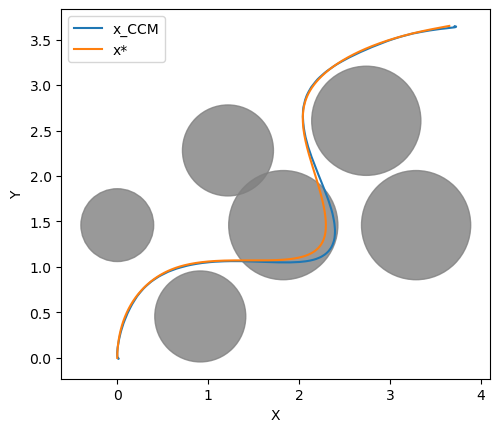

In [5]:
# obstacles = [
#     {'center': np.array([0, 1, 0.5]), 'radius': 0.4},
#     {'center': np.array([0.5, 1.8, 0.5]), 'radius': 0.4}
# ]
a = 3.65
obstacles = [
    {'center': np.array([0, a/2.5]), 'radius': 0.4},
    {'center': np.array([a/4, a/8]), 'radius': 0.5},
    {'center': np.array([a/3, a/1.6]), 'radius': 0.5},
    {'center': np.array([a/2, a/2.5]), 'radius': 0.6},
    {'center': np.array([(3.6*a)/4, a/2.5]), 'radius': 0.6},
    {'center': np.array([(3*a)/4, a/1.4]), 'radius': 0.6}
]

# Create 2D plot
fig, ax = plt.subplots()
for obs in obstacles:
    center = obs['center'][:2]  # Ignore Z
    radius = obs['radius']
    circle = plt.Circle(center, radius, color='gray', alpha=0.8)
    ax.add_patch(circle)

ax.plot(xcurr[:, 0], xcurr[:, 1], label='x_CCM')
ax.plot(Xstar[:, 0], Xstar[:, 1], label='x*')

# ax.scatter(Xstar[0,0], Xstar[0,1], color='green', label='Start')
# ax.scatter(Xstar[-1,0], Xstar[-1,1], color='red', label='Goal')

# Set limits and labels
ax.set_aspect('equal')
# ax.set_xlim(-1, 2)
# ax.set_ylim(0, 3)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
# plt.grid(True)

In [6]:
def dynamicsFunc_np(x, u, dt, g=9.81):
    vx = x[3]
    vy = x[4]
    vz = x[5]
    f  = x[6]
    phi = x[7]
    theta = x[8]

    x_dot = np.array([
        vx,
        vy,
        vz,
        -f * np.cos(theta) * np.sin(phi),
        f * np.sin(theta),
        -g + f * np.cos(theta) * np.cos(phi),
        u[0],  # dot(f)
        u[1],  # dot(phi)
        u[2]   # dot(theta)
    ])

    return x + dt * x_dot


def D_end(x_traj, u_traj, dt, gamma,w_lb,w_ub):
    T = x_traj.shape[0] - 1
    total = 0.0
    for k in range(T):
        w_k = x_traj[k + 1] - dynamicsFunc_np(x_traj[k], u_traj[k], dt)
        norm_w_k = np.linalg.norm(w_k)
        total += (gamma ** (k)) * norm_w_k
    return total 

def D_k_array(x_traj, u_traj, dt, gamma, w_lb, w_ub):
    T = x_traj.shape[0] - 1
    w_norms = np.zeros(T)
    for k in range(T):
        w_k = x_traj[k + 1] - dynamicsFunc_np(x_traj[k], u_traj[k], dt)
        w_norms[k] = np.linalg.norm(w_k)

    D_k = np.zeros(T)
    for k in range(T):
        discounts = gamma ** np.arange(0, k + 1)  # include gamma^k
        D_k[k] = np.sum(discounts * w_norms[:k + 1])

    return D_k 


def compute_lyapunov_modelling_error(xcurr,u, Xstar, w_func, w_lb, w_ub, gamma,dt):
    # Ensure matching shapes
    # Xstar = Xstar.T  # Make sure nominal trajectory is (T, 9)
    assert xcurr.shape == Xstar.shape, "xcurr and Xstar must have the same shape"

    T = xcurr.shape[0]
    error = np.zeros(T)

    for i in range(T - 1):
        x = xcurr[i]
        x_next =     dynamicsFunc_np(x, u[i], dt)                    #xcurr[i + 1]
        x_star = Xstar[i]
        x_star_next = Xstar[i + 1]

        M_next = np.linalg.inv(w_func(x_next))
        M_curr = np.linalg.inv(w_func(x))
 

        v_next = x_next - x_star_next
        v_curr = x - x_star

        V_next = np.sqrt(v_next.T @ M_next @ v_next)
        V_curr = np.sqrt(v_curr.T @ M_curr @ v_curr)

        f_term = np.sqrt(w_ub / w_lb) * V_next
        s_term = gamma * V_curr

        print("f_term :",f_term, " | s_term :",s_term)

        error[i] = np.max([0, f_term- s_term])

    return error

def compute_angle_rates(att_target, dt):
    """
    Computes approximate commanded roll and pitch rates from commanded roll/pitch angle commands.

    Returns:
        roll_rate_cmd, pitch_rate_cmd: numpy arrays of shape (N-1,) in radians/sec
    """
    # Finite difference (forward difference)
    roll_deg = att_target[:, 0]
    pitch_deg = att_target[:, 1]

    # Compute rate in deg/s
    roll_rate_deg = np.diff(roll_deg) / dt
    pitch_rate_deg = np.diff(pitch_deg) / dt

    # Convert to radians/sec
    roll_rate_rad = np.deg2rad(roll_rate_deg)
    pitch_rate_rad = np.deg2rad(pitch_rate_deg)

    return roll_rate_rad, pitch_rate_rad


0.11856283759745372
Estimated mean: [ 3.43552164e-04  1.10462155e-05 -1.08743492e-05 -1.52091003e-03
 -2.19327721e-03  1.07891427e-04 -4.74809664e-04 -5.40707689e-03
  7.43789885e-03]
Estimated covariance:
 [[ 1.37106907e-05  3.62471350e-06 -3.18719837e-07  7.67460074e-07
  -1.84882247e-06 -8.51777594e-08 -1.02080872e-05  2.53085462e-06
   4.68745320e-07]
 [ 3.62471350e-06  9.35671958e-06  2.21426043e-09  2.97502269e-06
  -8.79023281e-07 -2.83607754e-07 -7.94519334e-06  8.08090486e-07
  -1.71692276e-06]
 [-3.18719837e-07  2.21426043e-09  3.80186302e-08  3.27649957e-08
  -4.02712066e-09  1.08047122e-08  4.29125580e-07  3.19638176e-07
   4.15167927e-08]
 [ 7.67460074e-07  2.97502269e-06  3.27649957e-08  3.67153215e-05
  -1.24586123e-05 -6.90091259e-07  4.65038278e-05  6.36879471e-05
   2.39661678e-05]
 [-1.84882247e-06 -8.79023281e-07 -4.02712066e-09 -1.24586123e-05
   1.49389632e-05 -4.74832960e-07 -1.41533635e-05 -4.35373071e-05
  -2.64819497e-05]
 [-8.51777594e-08 -2.83607754e-07  1.0

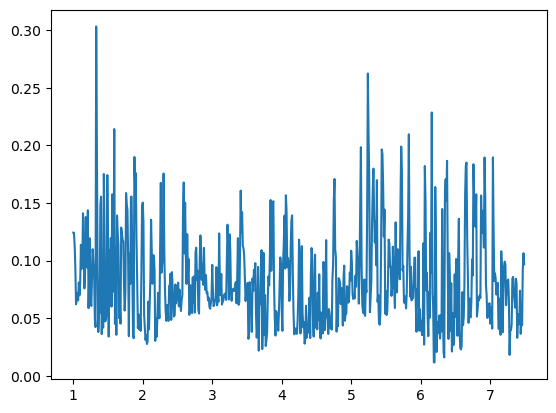

In [ ]:
def mle_gaussian(samples):
    # Number of samples
    N = samples.shape[0]
    
    # Empirical mean (1D array of shape (d,))
    mu_hat = np.mean(samples, axis=0)

    # Centered samples
    centered = samples - mu_hat

    # Empirical covariance (divide by N, not N-1 for MLE)
    Sigma_hat = (centered.T @ centered) / N

    return mu_hat, Sigma_hat
# PLOT DYNAMICS ERROR NORM VALUES
T = xcurr.shape[0] - 1  # we compute up to x_{T-1}, so x_{k+1} is within bounds

w = np.zeros((T, xcurr.shape[1]))
w_norms = np.zeros(T)


roll_rate_rad,pitch_rate_rad = compute_angle_rates(att_target, dt)

for k in range(T):
    w[k] = xcurr[k+1,:] - dynamicsFunc_np(xcurr[k,:], u[k,:], dt)
    # w[k] = xcurr[k+1,:] - dynamicsFunc_np(xcurr[k,:], [u[k,0],roll_rate_rad[k],pitch_rate_rad[k]], dt)
    w_norms[k] = np.linalg.norm(w[k])

plt.plot(timestamp[100:-1],w_norms[100:])
print(np.mean(w_norms))

mu_hat, Sigma_hat = mle_gaussian(w[100:,:])
print("Estimated mean:", mu_hat)
print("Estimated covariance:\n", Sigma_hat)

# SAVE GAUSSIAN ESTIMATES
# np.savez("CrazyflieNoise_params.npz", mu_hat=mu_hat, Sigma_hat=Sigma_hat)

In [8]:
#DISCOUNTED SUM
D = D_end(xcurr, u, dt, gamma,w_lb,w_ub)
print("Discounted w sum CP term over approx:", D)

D_k = D_k_array(xcurr, u, dt, gamma,w_lb,w_ub)
print(D_k[-1])

Discounted w sum CP term over approx: 0.585192557153839
0.585192557153839


f_term : 0.461572464538037  | s_term : 0.004954308139918416
f_term : 0.7570477328085502  | s_term : 0.0192891444415593
f_term : 0.7577387043481136  | s_term : 0.019305293823730096
f_term : 1.6216505038578437  | s_term : 0.04622747757122805
f_term : 4.330896749111419  | s_term : 0.10008643613266409
f_term : 4.056200326682379  | s_term : 0.09587984210567553
f_term : 3.4793610779661748  | s_term : 0.08622910025122457
f_term : 2.6559668116492112  | s_term : 0.069824664771966
f_term : 2.5870905990320168  | s_term : 0.06831452780046253
f_term : 2.4726198114638063  | s_term : 0.06528181174772854
f_term : 1.9425181749876015  | s_term : 0.0515315828674529
f_term : 1.6695249680051085  | s_term : 0.04290273681972617
f_term : 1.5549364481764671  | s_term : 0.03848997330020335
f_term : 1.5060713096771028  | s_term : 0.03599430516924657
f_term : 1.403077082123749  | s_term : 0.03151833035375031
f_term : 1.407790064786647  | s_term : 0.03156541780414178
f_term : 1.1698477681364507  | s_term : 0.02001

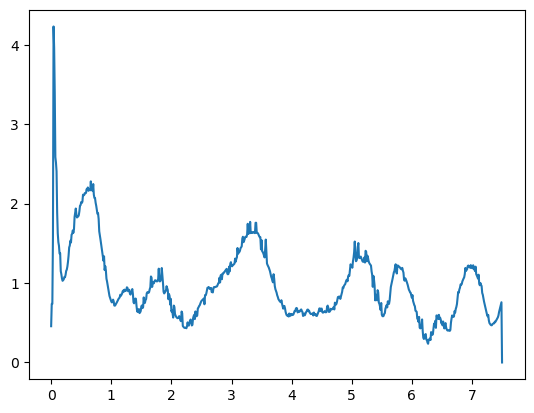

In [9]:
#LYAPUNOV MODELLING ERROR
error = compute_lyapunov_modelling_error(xcurr,u, Xstar, w_func, w_lb, w_ub, gamma,dt)
deltaV = np.max(error)
print("DeltaV :",deltaV)
plt.plot(timestamp,error)

fac : 6.547250011640287


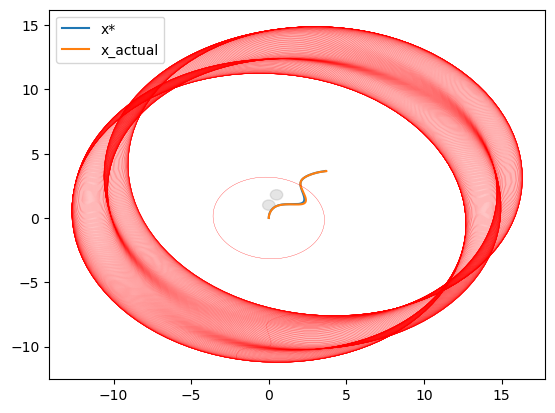

In [10]:
# Plot expected constraint tightening
obstacles = [
    {'center': np.array([0, 1, 0.5]), 'radius': 0.4},
    {'center': np.array([0.5, 1.8, 0.5]), 'radius': 0.4}
]

# Create 2D plot
fig, ax = plt.subplots()

for obs in obstacles:
    center = obs['center'][:2]  # Ignore Z
    radius = obs['radius']
    circle = plt.Circle(center, radius, color='gray', alpha=0.2)
    ax.add_patch(circle)


ax.plot(Xstar[:,0],Xstar[:,1], label="x*")
ax.plot(xcurr[:,0],xcurr[:,1], label="x_actual")
theta = np.linspace(0, 2*np.pi, 100)
circle = np.vstack((np.cos(theta), np.sin(theta))) 
for i in range(0,xcurr.shape[0]-1,5):
    fac=  np.sqrt(1/w_lb)* D + deltaV*((1-gamma**i)/(1-gamma))
    # print(fac)
    mu = Xstar[i,0:2]
    Sigma = np.array(w_func(Xstar[i,:]))[:2,:2] 
    # Sigma = np.eye(2)
    # dist = np.sqrt((xstar[i,0,0]-5)**2 + (xstar[i,1,0]-0)**2 )
    # n_vec = (1 - 1.2/dist)*(1/(dist-1.2))* np.array([np.array(xstar[i,0,0])-5,np.array(xstar[i,1,0])-0,0,0]);


    # Eigen decomposition
    D_eig, V = np.linalg.eigh(fac**2 *Sigma)
    ellipse = V @ np.diag(np.sqrt(D_eig)) @ circle
    ellipse += mu[:, None]

    # Plot ellipsoid
    ax.plot(ellipse[0, :], ellipse[1, :], 'r', linewidth=0.2)

    # M_matrix =  np.linalg.inv(w_func(Xstar[i,:]))
    # eigvals = np.linalg.eigvalsh(M_matrix)  # since M is symmetric
    # lambda_max,lambda_min = np.max(eigvals), np.min(eigvals)
    # print("m_lb :",lambda_min,"m_ub :",lambda_max)

ax.legend()
print("fac :",fac)
# 0.188